### Introduction to Monte Carlo Simulation in Finance
# Multiasset Simulation

## Cholesky Decomposition

The **Choleski Decomposition** makes an appearance in Monte Carlo Methods where it is used to simulating systems with correlated variables.  Cholesky decomposition is applied to the correlation matrix, providing a lower triangular matrix $A$, which when applied to a vector of uncorrelated samples, $u$, produces the covariance vector of the system. Thus it is highly relevant for quantitative trading.

The standard procedure for generating a set of correlated normal random variables is through a linear combination of uncorrelated normal random variables;
Assume we have a set of $n$ independent standard normal random variables $Z$ and we want to build a set of $n$ correlated standard normals $Z^\prime$ with correlation matrix $\Sigma$
$$
Z^\prime = AZ, \quad \quad AA^t = \Sigma
$$

We can find a solution for $A$ in the form of a triangular matrix
$$
\begin{pmatrix} 
A_{11} & 0 & \dots & 0  \\ 
A_{21} & A_{22} & \dots & 0  \\ 
\vdots & \vdots & \ddots & \dots  \\ 
A_{n1} & A_{n2} & \dots & A_{nn}   
\end{pmatrix}
$$

**diagonal elements**
$$
a_{ii} = \sqrt{\Sigma_{ii} - \sum\limits_{k=1}^{i-1} a_{ik}^2}
$$

**off-diagonal elements**
$$
a_{ij} = \frac{1}{a_{ii}} \left( \Sigma_{ij} - \sum\limits_{k=1}^{i-1} a_{ik} a_{jk} \right)
$$

Using Python, the most efficient method in both development and execution time is to make use of the NumPy/SciPy linear algebra (linalg) library, which has a built in method cholesky to decompose a matrix. The optional lower parameter allows us to determine whether a lower or upper triangular matrix is produced: 

In [117]:
import pprint
import scipy
import scipy.linalg   # SciPy Linear Algebra Library

A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
L = scipy.linalg.cholesky(A, lower=True)
U = scipy.linalg.cholesky(A, lower=False)

print "A:"
pprint.pprint(A)

print "L:"
pprint.pprint(L)

print "U:"
pprint.pprint(U)

A:
array([[ 6,  3,  4,  8],
       [ 3,  6,  5,  1],
       [ 4,  5, 10,  7],
       [ 8,  1,  7, 25]])
L:
array([[ 2.44948974,  0.        ,  0.        ,  0.        ],
       [ 1.22474487,  2.12132034,  0.        ,  0.        ],
       [ 1.63299316,  1.41421356,  2.30940108,  0.        ],
       [ 3.26598632, -1.41421356,  1.58771324,  3.13249102]])
U:
array([[ 2.44948974,  1.22474487,  1.63299316,  3.26598632],
       [ 0.        ,  2.12132034,  1.41421356, -1.41421356],
       [ 0.        ,  0.        ,  2.30940108,  1.58771324],
       [ 0.        ,  0.        ,  0.        ,  3.13249102]])


For example, for a two-dimension random vector we have simply
$$
A=
\begin{pmatrix} 
\sigma_1        & 0   \\ 
\sigma_2 \rho & \sigma_2 \sqrt{1-\rho^2}   
\end{pmatrix}
$$

Say one needs to generate two correlated normal variables $x_1$ and $x_2$. All one needs to do is to generate two uncorrelated Gaussian random variables $z_1$ and$ z_2$ and set
$$
x_1 = z_1 
$$

$$
x_2 =  \rho z_1 + \sqrt{1-\rho^2} z_2
$$

In Python everything you need is available in the *numpy* library, as we can see in the next example.

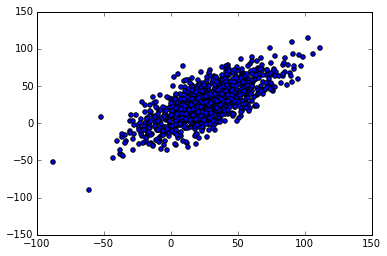

In [118]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds  = [xx.std()  , yy.std() ]
corr  = 0.75      # correlation
covs  = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
scatter(m[0], m[1])

## Brownian simulation of correlated assets

When using Monte Carlo methods to price options dependent on a basket of underlying assets (multidimensional stochastic simulations), the correlations between assets should be considered. Here I will show an example of how this can be simulated using pandas. 

Download and prepare the data

First we download some data from Yahoo:

In [119]:
import warnings; warnings.simplefilter('ignore')

from pandas_datareader import DataReader
from pandas import Panel, DataFrame

symbols = ['WIKI/AAPL','WIKI/MCD','WIKI/IBM']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2017-01-01'
end_date   = '2017-12-31'

data = dict((symbol, DataReader(symbol, "quandl", start_date, end_date)) for symbol in symbols)

panel = Panel(data).swapaxes('items', 'minor')
closing = panel['Close'].dropna()
closing.tail()

,WIKI/AAPL,WIKI/IBM,WIKI/MCD
Date,,,
2017-12-22,175.01,152.50,171.42
2017-12-26,170.57,152.83,171.29
2017-12-27,170.60,153.13,172.67
2017-12-28,171.08,154.04,173.10
2017-12-29,169.23,153.42,172.12


Now we can calculate the log returns:

In [120]:
rets = log(closing / closing.shift(1)).dropna()
rets.tail()

,WIKI/AAPL,WIKI/IBM,WIKI/MCD
Date,,,
2017-12-22,0.000000,0.006579,-0.002505
2017-12-26,-0.025697,0.002162,-0.000759
2017-12-27,0.000176,0.001961,0.008024
2017-12-28,0.002810,0.005925,0.002487
2017-12-29,-0.010873,-0.004033,-0.005678


The correlation matrix has information about the historical correlations between stocks in the group. We work under the assumption that this quantity is conserved, so the generated stocks will need to satisfy this condition:

In [121]:
corr_matrix = rets.corr()
corr_matrix

,WIKI/AAPL,WIKI/IBM,WIKI/MCD
WIKI/AAPL,1.000000,-0.032244,0.184662
WIKI/IBM,-0.032244,1.000000,0.038858
WIKI/MCD,0.184662,0.038858,1.000000


So the most correlated assets are MCD (McDonald's Corporation) and the SPX (S&P 500 Index). Pandas has a nice utility to plot the correlations:

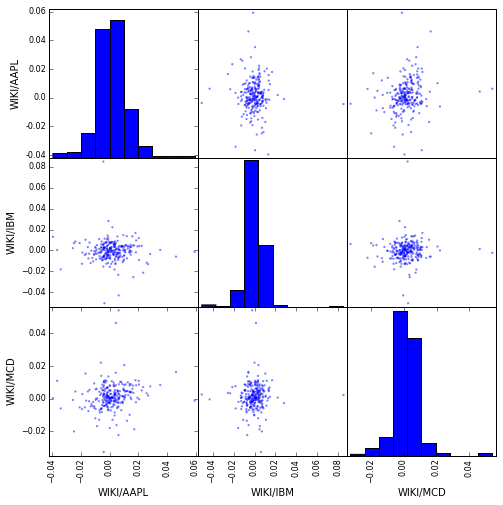

In [122]:
import pandas
from pandas import plotting
from pandas.plotting import scatter_matrix


scatter_matrix(rets, figsize=(8,8));

### Simulation

The simulation procedure for generating random variables will go like this:

1. Calculate the Cholesky Decomposition matrix, this step will return an upper triangular matrix  $L^T$.
2. Generate random vector  $X \sim N(0,1)$.
3. Obtain a correlated random vector  $Z=XL^T$.

As we have previously seen the Cholesky decomposition of the correlation matrix corr_matrix is impemented in scipy:

In [123]:
from scipy.linalg import cholesky

upper_cholesky = cholesky(corr_matrix, lower=False)
upper_cholesky

array([[ 1.        , -0.0322435 ,  0.18466248],
       [ 0.        ,  0.99948004,  0.04483594],
       [ 0.        ,  0.        ,  0.98177875]])

We set up the parameters for the simulation:

In [124]:
import numpy as np 
from pandas import bdate_range   # business days

n_days = 21
dates = bdate_range(start=closing.iloc[-1].name, periods=n_days)
n_assets = len(symbols)
n_sims = 1000
dt = 1./252
mu = rets.mean().values
sigma = rets.std().values*sqrt(252)
np.random.seed(1234)            # init random number generator for reproducibility

Now we generate the correlated random values $X$:

In [125]:
rand_values = np.random.standard_normal(size = (n_days * n_sims, n_assets)) #
corr_values = rand_values.dot(upper_cholesky)*sigma
corr_values

array([[ 0.08386717, -0.19087816,  0.18653151],
       [-0.05562001, -0.11243672,  0.10114332],
       [ 0.15291869, -0.10511793,  0.01885766],
       ..., 
       [-0.02979227, -0.10492133, -0.03556684],
       [-0.31595431, -0.22611523, -0.04210147],
       [-0.08108562,  0.03448783, -0.10580333]])

With everything set up we can start iterating through the time interval. The results for each specific time are saved along the third axis of a pandas Panel.

In [126]:
nAsset = 3
prices = Panel(items=range(n_sims), minor_axis=symbols, major_axis=dates)
prices.iloc[:, 0, :] = closing.iloc[-1].values.repeat(n_sims).reshape(nAsset,n_sims).T # set initial values

for i in range(1,n_days):
    prices.iloc[:, i, :] = prices.iloc[:, i-1,:] * (exp((mu-0.5*sigma**2)*dt +  sqrt(dt)*corr_values[i::n_days])).T    

prices.iloc[123, :, :].head()   # show random path

,WIKI/AAPL,WIKI/MCD,WIKI/IBM
2017-12-29,169.230000,153.420000,172.120000
2018-01-01,170.247911,151.846049,176.058046
2018-01-02,166.029559,151.184072,173.592755
2018-01-03,163.383184,149.446943,171.973217
2018-01-04,164.050626,150.668059,172.935994


And thats all! Now it is time to check our results. First a plot of all random paths for AAPL (Apple Inc.).

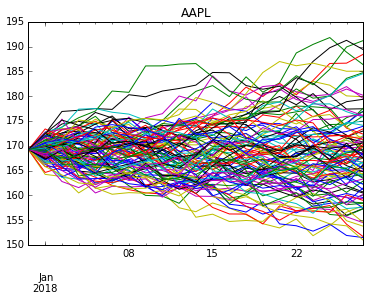

In [127]:
prices.loc[::10, :, 'WIKI/AAPL'].plot(title='AAPL', legend=False);

We can take a look at the statistics for the last day:

In [128]:
prices.iloc[:, -1, :].T.describe()

,WIKI/AAPL,WIKI/MCD,WIKI/IBM
count,1000.000000,1000.000000,1000.000000
mean,168.872165,153.734571,172.081073
std,8.589916,6.772940,6.151410
min,142.193127,135.467124,152.185459
25%,162.744089,149.299153,167.878999
50%,168.824026,153.554205,172.049592
75%,174.283957,158.121257,176.304479
max,197.107067,181.782396,189.811779
